In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [4]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using BenchmarkTools
using TransportMap
using QuadGK
using Distributions
using Random
using LoopVectorization
using Test
using SparseArrays
using AdaptiveTransportMap: vander, transform!, evaluate, ncoeff, optimize, negative_log_likelihood!, derivative
using Quadrature
using Cubature
using FiniteDiff
using Test

In [140]:
Nx = 3
Ne = 100
ens = EnsembleState(Nx, Ne)
ens.S .= randn(Nx, Ne)

B = MultiBasis(CstProHermite(3), Nx)

idx = [1 0 0; 0 1 0; 0 2 0; 0 3 0; 0 0 1; 0 0 2; 0 2 2]
truncidx = idx[1:2:end,:]
coeff =  randn(size(idx,1))

f = ExpandedFunction(B, idx, coeff)


# Verify grad_x_grad_xd
dxdxkψ = grad_x_grad_xd(f, ens.S)

for i=1:Ne
    dxdxkψ_t = ForwardDiff.hessian(f, member(ens,i))
    for j=1:Nx
        @test abs(dxdxkψ[i,j] - dxdxkψ_t[j,end])<1e-10
    end
end

# Verify hess_x_grad_xd
dxidxjdxkψ = hess_x_grad_xd(f, ens.S, f.idx)

for i=1:Ne
    dxidxjdxkψ_t = ForwardDiff.hessian(xi ->ForwardDiff.gradient(f, xi)[Nx], member(ens,i))
    @test norm(dxidxjdxkψ[i,:,:] - dxidxjdxkψ_t)<1e-10
end

In [26]:
midxj = idx[:,1]
maxj = maximum(midxj)
Xj = view(ens.S,1,:)

100-element view(::Array{Float64,2}, 1, :) with eltype Float64:
 -0.810365307846789
 -0.6069765937887996
  0.11310427331510484
  0.4215363542400613
 -0.784040728480158
 -0.6636266676535612
 -0.1361577332326958
  1.5370930351551562
  2.451149459944795
 -0.5804127291246107
 -0.6888712039938152
 -0.02385317612252713
 -0.20983519951747387
  ⋮
 -2.8131851206175846
  0.7132993987531777
  1.1582542784623682
 -0.9767182113990016
 -1.5394519725052254
  1.5301821628229504
 -0.8998896811274109
 -0.06503121310553667
  0.6034527302202422
 -1.9554655447178313
  0.3383166242323715
  0.4733627470618142

In [34]:
f.dim[ f.dim .<3]

1-element Array{Int64,1}:
 2

In [136]:
# @testset "Test evaluation, gradient and hessian of expanded function Nx = 3 I" begin

    Nx = 3
    Ne = 500
    ens = EnsembleState(Nx, Ne)
    ens.S .= randn(Nx, Ne)

    B = MultiBasis(CstProHermite(3), Nx)

    idx = [0 0 0; 2 0 1; 0 1 0; 0 2 1; 0 1 2; 1 0 0; 2 2 2]
    truncidx = idx[1:2:end,:]
    coeff =  randn(size(idx,1))

    f = ExpandedFunction(B, idx, coeff)

    ψt_basis, dψt_basis, d2ψt_basis = alleval(f, ens)

    ψ_basis = evaluate_basis(f, ens.S)
    dψ_basis = grad_x_basis(f, ens.S)
    d2ψ_basis = hess_x_basis(f, ens.S);
    @test norm(ψt_basis - ψ_basis)<1e-8
    @test norm(dψt_basis - dψ_basis)<1e-8
    @test norm(d2ψt_basis - d2ψ_basis)<1e-8


    # For truncated basis
    ψtrunc_basis = evaluate_basis(f, ens.S, truncidx)
    dψtrunc_basis = grad_x_basis(f, ens.S, truncidx)
    d2ψtrunc_basis = hess_x_basis(f, ens.S, truncidx);

    @test norm(ψ_basis[:,1:2:end] - ψtrunc_basis)<1e-8
    @test norm(dψ_basis[:,1:2:end,:] - dψtrunc_basis)<1e-8
    @test norm(d2ψt_basis[:,1:2:end,:,:] - d2ψtrunc_basis)<1e-8


    # Verify function evaluation
    @test norm(map(i->f(member(ens,i)),1:Ne) - evaluate(f, ens.S))<1e-8

    #  Verify gradient
    dψ = grad_x(f, ens.S)
    @test norm(hcat(map(i->ForwardDiff.gradient(f, member(ens,i)), 1:Ne)...)' - dψ)<1e-8

    # Verify hessian
    d2ψ = hess_x(f, ens.S)

    for i=1:Ne
        d2ψt = ForwardDiff.hessian(f, member(ens,i))
        @test norm(d2ψt - d2ψ[i,:,:])<1e-8
    end


    # Verify grad_xd
    dψxd = grad_xd(f, ens.S)

    for i=1:Ne
        dψxd_t = ForwardDiff.gradient(f, member(ens,i))[end]
        @test abs(dψxd[i] - dψxd_t)<1e-10
    end

    # Verify hess_xd
    d2ψxd = hess_xd(f, ens.S)

    for i=1:Ne
        d2ψxd_t = ForwardDiff.hessian(f, member(ens,i))[end,end]
        @test abs(d2ψxd[i] - d2ψxd_t)<1e-10
    end

    # Verify grad_x_grad_xd
    dxdxkψ = grad_x_grad_xd(f, ens.S)

    for i=1:Ne
        dxdxkψ_t = ForwardDiff.hessian(f, member(ens,i))
        for j=1:Nx
            @test abs(dxdxkψ[i,j] - dxdxkψ_t[j,end])<1e-10
        end
    end

    # Verify hess_x_grad_xd
    dxidxjdxkψ = hess_x_grad_xd(f, ens.S, f.idx)

    for i=1:Ne
        dxidxjdxkψ_t = ForwardDiff.hessian(xi ->ForwardDiff.gradient(f, xi)[Nx], member(ens,i))
        @test norm(dxidxjdxkψ[i,:,:] - dxidxjdxkψ_t)<1e-10
    end

#     # Verify grad_coeff
#     dψcoeff  = grad_coeff(f, ens.S)
#     dψcoefftrunc  = grad_coeff(f, ens.S, collect(1:2:size(idx,1)))
#     @test norm(dψcoeff[:,1:2:end] - dψcoefftrunc)<1e-10

#     @test norm(dψcoeff - ψ_basis)<1e-10
#     @test norm(dψcoefftrunc - ψtrunc_basis)<1e-10

#     # Verify hess_coeff
#     d2ψcoeff  = hess_coeff(f, ens.S)
#     d2ψcoefftrunc  = hess_coeff(f, ens.S, collect(1:2:size(idx,1)))

#     @test norm(d2ψcoeff)<1e-10

#     # Verify grad_coeff_grad_xd
#     dψcoeffxd = grad_coeff_grad_xd(f, ens.S)
#     dψcoeffxdtrunc = grad_coeff_grad_xd(f, ens.S, collect(1:2:size(idx,1)))

#     @test norm(dψcoeffxd[:,1:2:end] - dψcoeffxdtrunc)<1e-10
#     @test norm(dψcoeffxd - grad_xk_basis(f, ens.S, 1, Nx))<1e-10
#     @test norm(dψcoeffxdtrunc - grad_xk_basis(f, ens.S, 1, Nx, f.idx[collect(1:2:size(idx,1)),:]))<1e-10

#     # Verify hess_coeff_grad_xd
#     d2ψcoeffxd = hess_coeff_grad_xd(f, ens.S)
#     d2ψcoeffxdtrunc = hess_coeff_grad_xd(f, ens.S, collect(1:2:size(idx,1)))

#     @test norm(d2ψcoeffxd)<1e-10
#     @test norm(d2ψcoeffxdtrunc)<1e-10
# end

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [137]:

@testset "Test evaluation, gradient and hessian of expanded function Nx = 3 I" begin

    Nx = 3
    Ne = 500
    ens = EnsembleState(Nx, Ne)
    ens.S .= randn(Nx, Ne)

    B = MultiBasis(CstProHermite(3), Nx)

    idx = [0 0 0; 0 0 1; 0 1 0; 0 2 1; 0 1 2; 0  3 0; 0 2 2]
    truncidx = idx[1:2:end,:]
    coeff =  randn(size(idx,1))

    f = ExpandedFunction(B, idx, coeff)

    ψt_basis, dψt_basis, d2ψt_basis = alleval(f, ens)

    ψ_basis = evaluate_basis(f, ens.S)
    dψ_basis = grad_x_basis(f, ens.S)
    d2ψ_basis = hess_x_basis(f, ens.S);
    @test norm(ψt_basis - ψ_basis)<1e-8
    @test norm(dψt_basis - dψ_basis)<1e-8
    @test norm(d2ψt_basis - d2ψ_basis)<1e-8


    # For truncated basis
    ψtrunc_basis = evaluate_basis(f, ens.S, truncidx)
    dψtrunc_basis = grad_x_basis(f, ens.S, truncidx)
    d2ψtrunc_basis = hess_x_basis(f, ens.S, truncidx);

    @test norm(ψ_basis[:,1:2:end] - ψtrunc_basis)<1e-8
    @test norm(dψ_basis[:,1:2:end,:] - dψtrunc_basis)<1e-8
    @test norm(d2ψt_basis[:,1:2:end,:,:] - d2ψtrunc_basis)<1e-8


    # Verify function evaluation
    @test norm(map(i->f(member(ens,i)),1:Ne) - evaluate(f, ens.S))<1e-8

    #  Verify gradient
    dψ = grad_x(f, ens.S)
    @test norm(hcat(map(i->ForwardDiff.gradient(f, member(ens,i)), 1:Ne)...)' - dψ)<1e-8

    # Verify hessian
    d2ψ = hess_x(f, ens.S)

    for i=1:Ne
        d2ψt = ForwardDiff.hessian(f, member(ens,i))
        @test norm(d2ψt - d2ψ[i,:,:])<1e-8
    end


    # Verify grad_xd
    dψxd = grad_xd(f, ens.S)

    for i=1:Ne
        dψxd_t = ForwardDiff.gradient(f, member(ens,i))[end]
        @test abs(dψxd[i] - dψxd_t)<1e-10
    end

    # Verify hess_xd
    d2ψxd = hess_xd(f, ens.S)

    for i=1:Ne
        d2ψxd_t = ForwardDiff.hessian(f, member(ens,i))[end,end]
        @test abs(d2ψxd[i] - d2ψxd_t)<1e-10
    end

    # Verify grad_x_grad_xd
    dxdxkψ = grad_x_grad_xd(f, ens.S)

    for i=1:Ne
        dxdxkψ_t = ForwardDiff.hessian(f, member(ens,i))
        for j=1:Nx
            @test abs(dxdxkψ[i,j] - dxdxkψ_t[j,end])<1e-10
        end
    end

    # Verify hess_x_grad_xd
    dxidxjdxkψ = hess_x_grad_xd(f, ens.S, f.idx)

    for i=1:Ne
        dxidxjdxkψ_t = ForwardDiff.hessian(xi ->ForwardDiff.gradient(f, xi)[Nx], member(ens,i))
        @test norm(dxidxjdxkψ[i,:,:] - dxidxjdxkψ_t)<1e-10
    end

    # Verify grad_coeff
    dψcoeff  = grad_coeff(f, ens.S)
    dψcoefftrunc  = grad_coeff(f, ens.S, collect(1:2:size(idx,1)))
    @test norm(dψcoeff[:,1:2:end] - dψcoefftrunc)<1e-10

    @test norm(dψcoeff - ψ_basis)<1e-10
    @test norm(dψcoefftrunc - ψtrunc_basis)<1e-10

    # Verify hess_coeff
    d2ψcoeff  = hess_coeff(f, ens.S)
    d2ψcoefftrunc  = hess_coeff(f, ens.S, collect(1:2:size(idx,1)))

    @test norm(d2ψcoeff)<1e-10

    # Verify grad_coeff_grad_xd
    dψcoeffxd = grad_coeff_grad_xd(f, ens.S)
    dψcoeffxdtrunc = grad_coeff_grad_xd(f, ens.S, collect(1:2:size(idx,1)))

    @test norm(dψcoeffxd[:,1:2:end] - dψcoeffxdtrunc)<1e-10
    @test norm(dψcoeffxd - grad_xk_basis(f, ens.S, 1, Nx))<1e-10
    @test norm(dψcoeffxdtrunc - grad_xk_basis(f, ens.S, 1, Nx, f.idx[collect(1:2:size(idx,1)),:]))<1e-10

    # Verify hess_coeff_grad_xd
    d2ψcoeffxd = hess_coeff_grad_xd(f, ens.S)
    d2ψcoeffxdtrunc = hess_coeff_grad_xd(f, ens.S, collect(1:2:size(idx,1)))

    @test norm(d2ψcoeffxd)<1e-10
    @test norm(d2ψcoeffxdtrunc)<1e-10
end

Test Summary:                                                       | Pass  Total
Test evaluation, gradient and hessian of expanded function Nx = 3 I | 3517   3517


Test.DefaultTestSet("Test evaluation, gradient and hessian of expanded function Nx = 3 I", Any[], 3517, false)

### Gradient and Hessian of the log pdf

In [110]:
Nx = 20
Ne = 100
m = 10

X = randn(Nx, Ne) .* randn(Nx, Ne) .+ randn(Nx)

idx =  [     0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
             0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
             0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
             0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
             0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
             0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
             0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

coeff =  [   -0.49080651135435777;
             -4.799206197116311;
              3.4759551706001104;
              1.4870557820886656;
             -3.060800371552232;
             -0.5226942791601018;
              1.306286626089186;
              0.8525225393801524;
             -0.4927461375456826;
              1.38234078088931];

In [111]:
C = MapComponent(m, Nx, idx, coeff)

MapComponent(10, 10, 20, IntegratedFunction(10, 10, 20, Rectifier("softplus"), ParametricFunction(ExpandedFunction(10, 10, 20, MultiBasis(Basis of 10 functions: Constant -> 8th degree Probabilistic Hermite function
, 20), [0 0 … 0 0; 0 0 … 0 1; … ; 2 0 … 0 0; 3 0 … 0 0], [1, 6, 7, 10, 15, 20], [-0.49080651135435777, -4.799206197116311, 3.4759551706001104, 1.4870557820886656, -3.060800371552232, -0.5226942791601018, 1.306286626089186, 0.8525225393801524, -0.4927461375456826, 1.38234078088931]))), 1.0e-6)

In [131]:
@time G = grad_x_log_pdf(C, X)

  0.002549 seconds (2.90 k allocations: 10.792 MiB)


100×20 Array{Float64,2}:
 -0.128438   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0   0.270045
 -0.271263   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   1.52993
 -0.240295   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   0.9527
  0.349774   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.502832
 -0.0963206  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   3.92315
 -0.299025   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0   1.616
  0.327455   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.569145
 -0.539773   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   2.70799
  0.185728   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   5.72899
  0.275285   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -1.32057
  0.568379   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  -1.26089
  0.625242   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -2.41894
  0.204835   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.675261
  ⋮                              ⋱  ⋮                   
 -1.6377     0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   3.42945
 -0.176

In [132]:
@time hess_x_log_pdf(C, X)

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [115]:
active_dim(C)

6-element Array{Int64,1}:
  1
  6
  7
 10
 15
 20

In [116]:
repeat(1:Ne,6)

600-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100

In [119]:
repeat(dim,(2,5))

LoadError: MethodError: no method matching repeat(::Array{Int64,1}, ::Tuple{Int64,Int64})
Closest candidates are:
  repeat(::AbstractArray{T,1} where T, !Matched::Integer) at abstractarraymath.jl:289
  repeat(::Union{AbstractArray{T,1}, AbstractArray{T,2}} where T, !Matched::Integer) at abstractarraymath.jl:275
  repeat(::Union{AbstractArray{T,1}, AbstractArray{T,2}} where T, !Matched::Integer, !Matched::Integer) at abstractarraymath.jl:275
  ...

In [129]:
using LinearAlgebra
using SparseArrays 

N = 200
Nx = 20

dim = [1; 2; 5; 8; 10; 14; 17; 20]

@time A  = sparse(repeat(1:N, length(dim)), vcat([i*ones(Int64, N) for i in dim]...), zeros(N*length(dim)), N, Nx)

  0.037198 seconds (69.06 k allocations: 3.637 MiB)


200×20 SparseMatrixCSC{Float64,Int64} with 1600 stored entries:
  [1  ,  1]  =  0.0
  [2  ,  1]  =  0.0
  [3  ,  1]  =  0.0
  [4  ,  1]  =  0.0
  [5  ,  1]  =  0.0
  [6  ,  1]  =  0.0
  [7  ,  1]  =  0.0
  [8  ,  1]  =  0.0
  [9  ,  1]  =  0.0
  [10 ,  1]  =  0.0
  [11 ,  1]  =  0.0
  [12 ,  1]  =  0.0
  ⋮
  [188, 20]  =  0.0
  [189, 20]  =  0.0
  [190, 20]  =  0.0
  [191, 20]  =  0.0
  [192, 20]  =  0.0
  [193, 20]  =  0.0
  [194, 20]  =  0.0
  [195, 20]  =  0.0
  [196, 20]  =  0.0
  [197, 20]  =  0.0
  [198, 20]  =  0.0
  [199, 20]  =  0.0
  [200, 20]  =  0.0

In [127]:
200*20

4000

In [ ]:
sparse(repeat(1:Ne, length(C.I.f.f.dim)), repeat(1:))

In [ ]:
sparse([1, 1, 2, 3], [1, 3, 2, 3], [0, 1, 2, 0])

In [107]:
@time hess_x_log_pdf(C, X)

  0.067985 seconds (228.26 k allocations: 162.846 MiB, 17.69% gc time)


100×20×20 Array{Float64,3}:
[:, :, 1] =
 -0.280767  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  -1.1252
  2.75019   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.411687
 -1.91345   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.388144
 -1.61304   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.372383
 -1.76468   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   0.494424
  5.12609   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0   0.246153
 -0.233609  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.412198
 -3.00433   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.203022
  0.731048  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.313041
  6.54366   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   0.0784955
  1.12652   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  -0.368726
  2.38521   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.560757
  2.53194   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   0.304031
  ⋮                             ⋱  ⋮                   
  3.93858   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  -0.29

In [79]:
?spzeros

search: spzeros



```
spzeros([type,]m[,n])
```

Create a sparse vector of length `m` or sparse matrix of size `m x n`. This sparse array will not contain any nonzero values. No storage will be allocated for nonzero values during construction. The type defaults to [`Float64`](@ref) if not specified.

# Examples

```jldoctest
julia> spzeros(3, 3)
3×3 SparseMatrixCSC{Float64,Int64} with 0 stored entries

julia> spzeros(Float32, 4)
4-element SparseVector{Float32,Int64} with 0 stored entries
```


In [80]:
?rmul!

search: rmul! elementproductmatmul! baremodule DiscreteMultivariateDistribution



```
rmul!(A::AbstractArray, b::Number)
```

Scale an array `A` by a scalar `b` overwriting `A` in-place.  Use [`lmul!`](@ref) to multiply scalar from left.  The scaling operation respects the semantics of the multiplication [`*`](@ref) between an element of `A` and `b`.  In particular, this also applies to multiplication involving non-finite numbers such as `NaN` and `±Inf`.

!!! compat "Julia 1.1"
    Prior to Julia 1.1, `NaN` and `±Inf` entries in `A` were treated inconsistently.


# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Array{Int64,2}:
 1  2
 3  4

julia> rmul!(A, 2)
2×2 Array{Int64,2}:
 2  4
 6  8

julia> rmul!([NaN], 0.0)
1-element Array{Float64,1}:
 NaN
```

---

```
rmul!(A, B)
```

Calculate the matrix-matrix product $AB$, overwriting `A`, and return the result. Here, `B` must be of special matrix type, like, e.g., [`Diagonal`](@ref), [`UpperTriangular`](@ref) or [`LowerTriangular`](@ref), or of some orthogonal type, see [`QR`](@ref).

# Examples

```jldoctest
julia> A = [0 1; 1 0];

julia> B = LinearAlgebra.UpperTriangular([1 2; 0 3]);

julia> LinearAlgebra.rmul!(A, B);

julia> A
2×2 Array{Int64,2}:
 0  3
 1  2

julia> A = [1.0 2.0; 3.0 4.0];

julia> F = qr([0 1; -1 0]);

julia> rmul!(A, F.Q)
2×2 Array{Float64,2}:
 2.0  1.0
 4.0  3.0
```


In [75]:
d2xkψ = repeated_hess_xk_basis(C.I.f.f, X[Nx,:])

100×5 Array{Float64,2}:
  0.0279996   0.0  0.0  0.0  0.0
 -0.157386    0.0  0.0  0.0  0.0
  0.00615114  0.0  0.0  0.0  0.0
 -0.156083    0.0  0.0  0.0  0.0
 -0.126448    0.0  0.0  0.0  0.0
  0.00379362  0.0  0.0  0.0  0.0
  0.10708     0.0  0.0  0.0  0.0
 -0.296084    0.0  0.0  0.0  0.0
 -0.309613    0.0  0.0  0.0  0.0
  0.140921    0.0  0.0  0.0  0.0
 -0.00838533  0.0  0.0  0.0  0.0
 -0.191811    0.0  0.0  0.0  0.0
 -0.307992    0.0  0.0  0.0  0.0
  ⋮                          
  0.00165065  0.0  0.0  0.0  0.0
 -0.154489    0.0  0.0  0.0  0.0
 -0.0761876   0.0  0.0  0.0  0.0
 -0.123063    0.0  0.0  0.0  0.0
  0.0593909   0.0  0.0  0.0  0.0
 -0.165164    0.0  0.0  0.0  0.0
 -0.21722     0.0  0.0  0.0  0.0
 -0.194644    0.0  0.0  0.0  0.0
 -0.204856    0.0  0.0  0.0  0.0
 -0.112701    0.0  0.0  0.0  0.0
 -0.303228    0.0  0.0  0.0  0.0
 -0.0170691   0.0  0.0  0.0  0.0

In [64]:
@time hess_x_log_pdf(C, X)

  0.015935 seconds (40.77 k allocations: 19.855 MiB)


100×10×10 Array{Float64,3}:
[:, :, 1] =
 -0.594507   -0.03015      0.0  0.0  …  0.0   0.0315965   0.0   0.332325
  0.181806   -0.025846     0.0  0.0     0.0  -0.0530615   0.0   0.374682
 -0.608387    0.000736923  0.0  0.0     0.0   0.00151176  0.0  -0.0782395
  0.0830548   0.00948195   0.0  0.0     0.0   0.00892893  0.0  -0.109014
 -0.205378    0.0165828    0.0  0.0     0.0  -0.0399832   0.0  -0.339931
 -0.853158    0.0425384    0.0  0.0  …  0.0  -0.0363867   0.0  -0.128934
 -0.873445    0.01898      0.0  0.0     0.0  -0.018577    0.0  -0.1179
 -0.780526    0.00376007   0.0  0.0     0.0   0.018608    0.0  -0.121824
 -0.124314    0.0551003    0.0  0.0     0.0   0.0470793   0.0  -0.277218
 -0.546538    0.023275     0.0  0.0     0.0   0.0233255   0.0  -0.21475
 -0.0556759   0.0121834    0.0  0.0  …  0.0   0.00159511  0.0  -0.343054
 -0.0352872   0.002024     0.0  0.0     0.0   0.00480559  0.0  -0.0479474
  0.0757107  -0.00391451   0.0  0.0     0.0   0.00152222  0.0   0.149649
  ⋮         

In [12]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


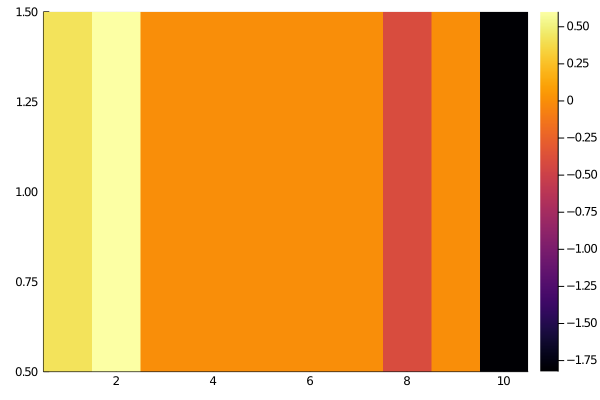

In [39]:
heatmap(G[1:1,:])

In [8]:
@time optimize(M, X, nothing; withqr = true, P = serial)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.321003 seconds (56.81 k allocations: 178.260 MiB, 18.10% gc time)


HermiteMap(10, 100, LinearTransform(100, [-1.9388115412536764, -0.5532840915970996, 0.6649510381692495, 0.8066244424946927, 1.4603598696781142, -1.4589681336803537, -0.9824037374192759, -0.20679245486456055, -1.1291131135026242, 0.6906625282794049  …  -0.37101560389918037, -0.7188384105130516, 1.9141484922491452, -0.41860810828244416, -1.6650320190314736, 1.410747568280138, -1.9536171293522333, 0.2517759861817628, -1.3866687836217055, 0.16619895667801496], [1.003333887605085 0.0 … 0.0 0.0; 0.0 0.889799322434419 … 0.0 0.0; … ; 0.0 0.0 … 1.0213865816432859 0.0; 0.0 0.0 … 0.0 0.9260049299342631], true), MapComponent[MapComponent(10, 10, 1, IntegratedFunction(10, 10, 1, Rectifier("softplus"), ParametricFunction(ExpandedFunction(10, 10, 1, MultiBasis(Basis of 10 functions: Constant -> 8th degree Probabilistic Hermite function
, 1), [1; 2; … ; 9; 10], [0.09564406871613584, -1.5235117095029267, 0.14859370117804918, -4.413286558881069, 0.6568369757672253, -3.796396743470617, 0.7444250305312987

In [ ]:
@time for i=1:Nx
    @show i
    hess_x_log_pdf(M.C[i], X[1:i,:])
end


In [ ]:
@time hess_x_log_pdf(M, X)

i = 1
i = 2
i = 3
i = 

### Integration

In [186]:
Nx = 100
Ny = 50
m = 20
Ne = 400
X = randn(Nx, Ne).*randn(Nx, Ne) #.+ 0.5*randn(Nx).*cos.(randn(Nx, Ne) .* randn(Nx, Ne))

# L = LinearTransform(X)
# transform!(L, X);
# C = MapComponent(m, Nx)
# @time C, _ = optimize(C, X, 10)

In [187]:
M = HermiteMap(m, X);

In [188]:
@time M_noqr = optimize(M, X, 10; P = serial, start = Ny+1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 19.530544 seconds (69.35 M allocations: 14.972 GiB, 7.45% gc time)


In [189]:
@time M_qr = optimize(M, X, 10; P = serial, withqr = true, start = Ny+1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


 10.677751 seconds (44.03 M allocations: 13.718 GiB, 9.93% gc time)


In [31]:
function timing()
    M = HermiteMap(m, X)
    @btime begin 
        optimize($M, $X, $10; P = serial, withqr = false, start = Ny+1)
    end
    
    @btime begin 
        optimize($M, $X, $10; P = serial, withqr = true, start = Ny+1)
    end
end

timing (generic function with 1 method)

In [32]:
timing();

  11.257 s (42606958 allocations: 13.65 GiB)
  21.346 s (45813192 allocations: 21.12 GiB)


In [11]:
timing();

  14.597 s (42433511 allocations: 13.37 GiB)


In [29]:
timing();

  973.450 ms (1054425 allocations: 1.43 GiB)


In [14]:
methods(update_component)

# 1 method for generic function "update_component":
[1] update_component(C::MapComponent, X, reduced_margin::Array{Int64,2}, S::Storage) in AdaptiveTransportMap at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/greedyfit.jl:249

In [30]:
function timing()
    @btime begin 
        M = HermiteMap($m, $X)
        optimize($M, $X, $10; P = thread)
    end
end

timing (generic function with 1 method)

In [88]:
timing();

  297.730 ms (1000725 allocations: 1.35 GiB)


### Test optimization with QR

In [45]:
Nx = 3
Ne = 8
m = 20

idx = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 0 1 2; 1 0 0]


Nψ = 6
coeff = [ 0.20649582065364197;
         -0.5150990160472986;
          2.630096893080717;
          1.13653076177397;
          0.6725837371023421;
         -1.3126095306624133]
C = MapComponent(m, Nx, idx, coeff; α = 1e-6);

Ne = 100


# The QR decomposition is not unique!

X = randn(Nx, Ne) .* randn(Nx, Ne) + cos.(randn(Nx, Ne)) .* exp.(-randn(Nx, Ne).^2)

L = LinearTransform(X)
transform!(L, X)
S = Storage(C.I.f, X)
F = QRscaling(S)
newidx = [1 1 1]

Snew = update_storage(S, X, newidx)
Fupdated = updateQRscaling(F, Snew)

Fnew = QRscaling(Snew)

@test norm(Fupdated.D - Fnew.D)<1e-8
@test norm(Fupdated.Dinv - Fnew.Dinv)<1e-8

Test Passed